### Plotting the ADCP spectra

In [1]:
import numpy as np
import scipy.io as io
import sys
import glob   
sys.path.append("../src/")

import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.basemap import Basemap
from netCDF4 import Dataset
import seawater as sw

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 26 days
Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 26 days


In [2]:
plt.rcParams.update({'font.size': 10
    , 'legend.markerscale': 1., 'axes.titlesize': 10, 'axes.labelsize' : 10,
      'legend.fontsize' : 8,'legend.handlelength': 3})

plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10)

In [3]:
lw1=4
aph=.7
sc = 20.

In [4]:
import dp_map
dpmap = dp_map.drake_passage_map(fig_label="a",fig_title="ADCP")
m = dpmap.m

In [5]:
# dataset
#data = np.load('outputs/mean_currents3.npz')
data = io.loadmat('../adcp/outputs/mean_var_26m.mat')
xgm,ygm = m(data['lon'],data['lat'])

fronts = Dataset('../adcp/outputs/SO_polar_fronts.v3.nc','r') 
lon_fronts = np.array(fronts.variables['lon'][:])
lat_saf = np.array(fronts.variables['latSAF'][:,:])
lat_pf = np.array(fronts.variables['latPF'][:,:])
time_fronts = np.array(fronts.variables['time'][:])
lon_fronts2 = np.repeat(lon_fronts,time_fronts.size).reshape(time_fronts.size,lon_fronts.size) 

lat_pfm = np.nanmean(lat_pf,axis=0)
lat_pfstd = np.nanstd(lat_pf,axis=0)
xpf,ypf=m(lon_fronts,lat_pfm)
xpfl,ypfl=m(lon_fronts,lat_pfm-lat_pfstd)
xpfu,ypfu=m(lon_fronts,lat_pfm+lat_pfstd)

# Lenn et al. 2008 Polar fronts
lenn = io.loadmat('../adcp/outputs/lenn_polar',squeeze_me=True,struct_as_record=False)

xlm,ylm = m(lenn['xip'],lenn['yipm'])
xlu,ylu = m(lenn['xip'],lenn['yipm']+lenn['yips'])
xll,yll = m(lenn['xip'],lenn['yipm']-lenn['yips'])

/Users/crocha/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/Users/crocha/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1136: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)


In [6]:
# masking
#U26 = np.ma.masked_array(data['U26'],data['NDOF26']<5)
#V26 = np.ma.masked_array(data['V26'],data['NDOF26']<5)
#var_U26 = np.ma.masked_array(data['var_U26'],data['NDOF26']<5)
#var_V26 = np.ma.masked_array(data['var_V26'],data['NDOF26']<5)
#var26=(var_U26+var_V26)/2.
#e26 = var_U26/var_V26; f = (e26<1.); #e26[f] = 1./e26[f]
#e26s = float((e26.mask == False).sum())

U26, V26 = data['u'], data['v']
eke = data['eke']
fmask = np.isnan(eke)
eke = np.ma.masked_array(eke,fmask)
U26 = np.ma.masked_array(U26,fmask)
V26 = np.ma.masked_array(V26,fmask)

Topography

In [7]:
topo = np.load("../topo/topo_dp.npz")
lont,latt,zt = topo['lon'],topo['lat'],topo['topo']
dec = 2
lont = lont[::dec]
latt = latt[::dec]
zt = zt[::dec,::dec]
lonti,latti = np.meshgrid(lont,latt)
xgt,ygt = m(lonti,latti)

In [8]:
import matplotlib.gridspec as gridspec

In [9]:
data_path = '../model/uv_0m_single_file.nc'
data = Dataset(data_path)

auxt = np.load('/Users/crocha/Dropbox/research/mitgcm/drake/subsets/eta_919_1440.npz')

In [10]:
flat = (data.variables['lat'][:] > -62) & (data.variables['lat'][:] < -55)
lon,lat = np.meshgrid(data.variables['lon'],data.variables['lat'][:][flat])
lon,lat = m(lon,lat)
time = auxt['time']

topo = np.load("../topo/topo_dp.npz")
lont,latt,zt = topo['lon'],topo['lat'],topo['topo']

dec = 1
lont = lont[::dec]
latt = latt[::dec]
zt = zt[::dec,::dec]
lonti,latti = np.meshgrid(lont,latt)
xgt,ygt = m(lonti,latti)

it = 7  # choose an arbitrary snapshot
speed = np.sqrt((data.variables['u'][flat,:,it]**2 +\
                 data.variables['v'][flat,:,it]**2))
speed = np.ma.masked_array(speed,speed>1.26)

In [11]:
u, v = data.variables['u'][flat,:,it], data.variables['v'][flat,:,it]


flat = (data.variables['lat'][:] > -62) & (data.variables['lat'][:] < -55)
loni,lati = np.meshgrid(data.variables['lon'],data.variables['lat'][:][flat])
ix,jx = loni.shape
DX = np.empty((ix-1,jx))
DY = np.empty((ix,jx-1))

for i in range(ix):
    DY[i,:],_ = sw.dist(lati[i,:],loni[i,:])
for j in range(jx):
    DX[:,j],_ = sw.dist(lati[:,j],loni[:,j])
    
dx, dy = DX.mean(), DY.mean()

uy,ux = np.gradient(u,dx,dy)
vy,vx = np.gradient(v,dx,dy)

zeta = vx - uy
div  = ux + vy

f = np.abs(sw.f(lati))
zeta = zeta/1.e3/f

In [12]:
fni = '../altimeter/tracks/*dat'
files=glob.glob(fni)

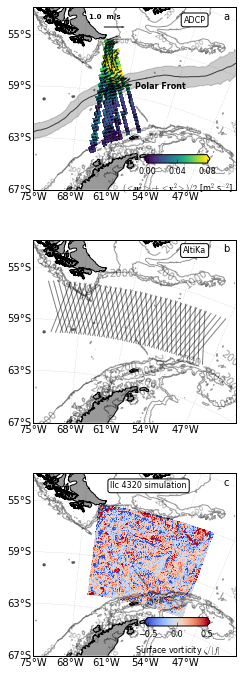

In [13]:
fig = plt.figure(figsize=(8.27/2-.5,11.69))
aph=0.35

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.25)

ax = fig.add_subplot(311)
cs = m.contour(xgt,ygt,-zt,np.array([200,1000,2000]),colors='k',alpha=.4)
plt.clabel(cs,inline=1,fontsize=7,fmt='%i')

pc = m.pcolor(xgm,ygm,eke,cmap='viridis',vmin=0.,vmax=0.08)

Q = m.quiver(xgm,ygm,U26,V26,color='k',scale=10,linewidths=.5,alpha=.75)

# quiver legend
qk = plt.quiverkey(Q, .35, .89, 1., '1.0  m/s',color='k',\
                   fontproperties={'weight': 'bold','size': '7'})

m.plot(xpf,ypf,'k',linewidth=1.,alpha=.7)
plt.fill_between(xpf,ypfl,ypfu, color='k', alpha=0.2)
plt.text(884397.07, 876462.09,'Polar Front',fontsize=8,fontweight='bold')

m.fillcontinents(color='.60',lake_color='none')
m.drawcoastlines()

dpmap.draw_par_mer()
dpmap.set_label(pos=(1650212,1475371))
dpmap.set_title(pos=(1400212,1475371))

axColor = plt.axes([.55,.7125,.25,.01])
cb = plt.colorbar(pc, cax = axColor, orientation="horizontal",
                  extend='both')

cb.set_label(u'$(\mathbf{<u^2>+<v^2>)/2}$ [m$^2$ s$^{-2}$]',fontsize=8)
cb.set_ticks(np.array([0.0,0.04,0.08]))
cb.ax.tick_params(labelsize=8) 


extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig('fig1a.png', bbox_inches=extent.expanded(1.3, 1.2))
fig.savefig('fig1a.eps', bbox_inches=extent.expanded(1.3, 1.2))
fig.savefig('fig1a.pdf', bbox_inches=extent.expanded(1.3, 1.2))

ax = fig.add_subplot(312)

dpmap = dp_map.drake_passage_map(fig_label="b",fig_title="AltiKa")
m = dpmap.m

cs = m.contour(xgt,ygt,-zt,np.array([200,1000,2000]),colors='k',alpha=.4)
plt.clabel(cs,inline=1,fontsize=10,fmt='%i')

for file in files:
    aux = np.loadtxt(file)
    lonaux,lataux = m(aux[:,0],aux[:,1])
    m.plot(lonaux,lataux,color='k',alpha=.5,linewidth=1.)

m.fillcontinents(color='.60',lake_color='none')
dpmap.draw_par_mer()
m.drawcoastlines()

dpmap.set_label(pos=(1650212,1485371))
dpmap.set_title(pos=(1400212,1495371))

extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig('fig1b.png', bbox_inches=extent.expanded(1.3, 1.2))
fig.savefig('fig1b.eps', bbox_inches=extent.expanded(1.3, 1.2))
fig.savefig('fig1b.pdf', bbox_inches=extent.expanded(1.3, 1.2))

ax = fig.add_subplot(313)
dpmap = dp_map.drake_passage_map(fig_label="c",fig_title="llc 4320 simulation")
m = dpmap.m
cs = m.contour(xgt,ygt,-zt,np.array([200,1000,2000]),colors='k',alpha=.4)
plt.clabel(cs,inline=1,fontsize=7,fmt='%i')

dec = 5
pc = m.pcolormesh(lon[::dec],lat[::dec],zeta[::dec],cmap='coolwarm',vmin=-.5,vmax=.5)
#pc = m.contourf(lon[::dec],lat[::dec],zeta[::dec],np.linspace(-.5,.5,100),cmap='coolwarm',
#                vmin=-.5,vmax=.5,extend='both')

#plt.clim(-.5,.5)
m.fillcontinents(color='.60',lake_color='none')
dpmap.draw_par_mer()
m.drawcoastlines()
dpmap.set_label(pos=(1650212,1475371))
dpmap.set_title(pos=(1000212,1475371))

axColor = plt.axes([.55,.1625,.25,.01])
cb = plt.colorbar(pc, cax = axColor, orientation="horizontal",
                  extend='both')

cb.set_label(u'Surface vorticity $\mathbf{\zeta}/|f|$',fontsize=8)
cb.set_ticks([-.5,0.0,.5])
cb.ax.tick_params(labelsize=8) 

# save subplot
extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig('fig1c.png', bbox_inches=extent.expanded(1.3, 1.15))
fig.savefig('fig1c.eps', bbox_inches=extent.expanded(1.3, 1.15))
fig.savefig('fig1c.pdf', bbox_inches=extent.expanded(1.3, 1.15))

#plt.savefig('fig1',dpi=300,bbox_inches='tight')
#plt.savefig('fig1.eps',dpi=300,bbox_inches='tight')
#plt.savefig('fig1.pdf',dpi=300,bbox_inches='tight')

plt.savefig('fig1',bbox_inches='tight',dpi=300)
plt.savefig('fig1.eps',bbox_inches='tight',dpi=80)
plt.savefig('fig1.pdf',bbox_inches='tight',dpi=80)


In [12]:
# snapshot, 100 m

In [13]:
data_path = '../model/uv_100m_single_file_small.nc'
data = Dataset(data_path)

flat = (data.variables['lat'][:] > -62) & (data.variables['lat'][:] < -55)
lon,lat = np.meshgrid(data.variables['lon'],data.variables['lat'][:][flat])
lon,lat = m(lon,lat)
time = auxt['time']

topo = np.load("../topo/topo_dp.npz")
lont,latt,zt = topo['lon'],topo['lat'],topo['topo']

dec = 1
lont = lont[::dec]
latt = latt[::dec]
zt = zt[::dec,::dec]
lonti,latti = np.meshgrid(lont,latt)
xgt,ygt = m(lonti,latti)

it = 700  # choose an arbitrary snapshot
speed = np.sqrt((data.variables['u'][flat,:,it]**2 +\
                 data.variables['v'][flat,:,it]**2))
speed = np.ma.masked_array(speed,speed>1.26)

dpmap = dp_map.drake_passage_map(fig_label=" ",fig_title="",fontsize=16)
m = dpmap.m

In [14]:
u, v = data.variables['u'][flat,:,it], data.variables['v'][flat,:,it]
 
flat = (data.variables['lat'][:] > -62) & (data.variables['lat'][:] < -55)
loni,lati = np.meshgrid(data.variables['lon'],data.variables['lat'][:][flat])
ix,jx = loni.shape
DX = np.empty((ix-1,jx))
DY = np.empty((ix,jx-1))

for i in range(ix):
    DY[i,:],_ = sw.dist(lati[i,:],loni[i,:])
for j in range(jx):
    DX[:,j],_ = sw.dist(lati[:,j],loni[:,j])
    
dx, dy = DX.mean(), DY.mean()

uy,ux = np.gradient(u,dx,dy)
vy,vx = np.gradient(v,dx,dy)

zeta = vx - uy
div  = ux + vy

f = np.abs(sw.f(lati))
zeta = zeta/1.e3/f

In [15]:
def vort_div(it):
    u, v = data.variables['u'][flat,:,it], data.variables['v'][flat,:,it]
    uy,ux = np.gradient(u,dx,dy)
    vy,vx = np.gradient(v,dx,dy)    
    zeta = vx - uy
    div  = ux + vy  
    return zeta/1.e3/f, div/1.e3/f

In [16]:
plt.rcParams.update({'font.size': 20
    , 'legend.markerscale': 1., 'axes.titlesize': 20, 'axes.labelsize' : 20,
      'legend.fontsize' : 16,'legend.handlelength': 3})

plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)

In [17]:

#for it in range(time.size):
for it in range(1343,time.size):


    zeta, div = vort_div(it)
    
    fig = plt.figure(figsize=(24,16))
    aph=0.35

    ax = fig.add_subplot(211)

    cs = m.contour(xgt,ygt,-zt,np.array([200,1000,2000]),colors='k',alpha=.4)
    plt.clabel(cs,inline=1,fontsize=7,fmt='%i')

    dec = 1
    pc = m.pcolormesh(lon[::dec],lat[::dec],zeta[::dec],cmap='coolwarm',vmin=-.5,vmax=.5)
    m.fillcontinents(color='.60',lake_color='none')
    dpmap.draw_par_mer()
    m.drawcoastlines()
    dpmap.set_label(pos=(1650212,1475371))
    dpmap.set_title(pos=(1000212,1475371))

    plt.title(str(time[it]))

    axColor = plt.axes([.53,.59,.1,.01])
    cb = plt.colorbar(pc, cax = axColor, orientation="horizontal",
                      extend='both')

    cb.set_label(u'Vorticity $\mathbf{\zeta}/|f|$',fontsize=14)
    cb.set_ticks([-.5,0.0,.5])
    cb.ax.tick_params(labelsize=14)

    if it < 10:
        tit = 'figs2movie/000'+str(it)+'.png'
    elif it <100:
        tit = 'figs2movie/00'+str(it)+'.png'
    elif it <1000:
        tit = 'figs2movie/0'+str(it)+'.png'
    else:
        tit = 'figs2movie/'+str(it)+'.png'
    
    plt.savefig(tit,bbox_inches='tight',dpi=80)
    plt.close()

In [ ]:
fig = plt.figure(figsize=(8.27/2-.5,11.69/2.))
aph=0.35

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.25)

ax = fig.add_subplot(211)

dec = 2
pc = m.pcolormesh(lon[::dec],lat[::dec],zeta[::dec],cmap='coolwarm',vmin=-.5,vmax=.5)
#pc = m.contourf(lon[::dec],lat[::dec],zeta[::dec],np.linspace(-.5,.5,100),cmap='coolwarm',
#                vmin=-.5,vmax=.5,extend='both')

#plt.clim(-.5,.5)
m.fillcontinents(color='.60',lake_color='none')
dpmap.draw_par_mer()
m.drawcoastlines()
dpmap.set_label(pos=(1650212,1475371))
dpmap.set_title(pos=(1000212,1475371))

#axColor = plt.axes([.55,.1625,.25,.01])
#cb = plt.colorbar(pc, cax = axColor, orientation="horizontal",
#                  extend='both')

#cb.set_label(u'Surface vorticity $\mathbf{\zeta}/|f|$',fontsize=8)
#cb.set_ticks([-.5,0.0,.5])
#cb.ax.tick_params(labelsize=8)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.25)

ax = fig.add_subplot(212)
dpmap = dp_map.drake_passage_map(fig_label="b",fig_title="llc 4320 simulation")
m = dpmap.m
cs = m.contour(xgt,ygt,-zt,np.array([200,1000,2000]),colors='k',alpha=.4)
plt.clabel(cs,inline=1,fontsize=7,fmt='%i')

dec = 5
pc = m.pcolormesh(lon[::dec],lat[::dec],div[::dec],cmap='coolwarm',vmin=-.04,vmax=.04)
#pc = m.contourf(lon[::dec],lat[::dec],zeta[::dec],np.linspace(-.5,.5,100),cmap='coolwarm',
#                vmin=-.5,vmax=.5,extend='both')

#plt.clim(-.5,.5)
m.fillcontinents(color='.60',lake_color='none')
dpmap.draw_par_mer()
m.drawcoastlines()
dpmap.set_label(pos=(1650212,1475371))
dpmap.set_title(pos=(1000212,1475371))

#cb = plt.colorbar(pc, orientation="horizontal",
#                  extend='both')

#cb.set_label(u'Surface vorticity $\mathbf{\zeta}/|f|$',fontsize=8)
#cb.set_ticks([-.25,0.0,.25])
#cb.ax.tick_params(labelsize=8)
plt.savefig('vort_div.png',bbox_inches='tight',dpi=80)